In [27]:
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np

def make_score_matrix(seq_a, seq_b, match_score=1, mismatch_score=0 ):
    score_matrix = np.zeros((len(seq_a), len(seq_b)))
    for i, a in enumerate(seq_a):
        for j, b in enumerate(seq_b):
            if a == b:
                score_matrix[i,j] = match_score
            else:
                score_matrix[i,j] = mismatch_score
    return score_matrix

def align_seq(seq_a, seq_b, gap_penalty=-1):
    score_matrix = make_score_matrix(seq_a, seq_b)
    from eden.util.NeedlemanWunsh import needleman_wunsh, trace_back
    needleman_wunsh_matrix = needleman_wunsh(seq_a, seq_b, score_matrix, gap_penalty)
    nw_score = needleman_wunsh_matrix[-1,-1]
    alignment_a, alignment_b = trace_back(seq_a, seq_b, score_matrix, needleman_wunsh_matrix, gap_penalty)
    return alignment_a, alignment_b, nw_score

In [30]:
def select_best_matching(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = -1
        max_motif = None
        for motif in motives:
            cluster_id, consensus_seq, regex_seq, trimmed_align_seqs, align_seqs, seqs = motif
            seq_a,seq_b, score = align_seq(orig_motif, consensus_seq)
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
                max_motif = motif
        yield max_motif
        
def best_matching_scores(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = -1
        max_motif = None
        for motif in motives:
            cluster_id, consensus_seq, regex_seq, trimmed_align_seqs, align_seqs, seqs = motif
            seq_a,seq_b, score = align_seq(orig_motif, consensus_seq)
            score = float(score)/len(orig_motif)
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
                max_motif = motif
        yield max_score

In [31]:
% matplotlib inline
import pylab as plt 
import numpy as np
from sklearn.metrics import roc_auc_score

def plot_cumulative_score(smod, pos_seqs, sequence_length=None, motif_length=None):
    sig = None
    for scores in smod.score(pos_seqs):
        if sig is None:
            sig = np.array(scores)
        else:
            sig += np.array(scores)
    sig=np.array(sig)
    
    truth = np.zeros(len(sig))
    truth[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]=1
    roc = roc_auc_score(truth, sig)
    print 'Cumulative score ROC: %.2f' % roc


    plt.figure(figsize=(16,3))
    sigp = np.copy(sig)
    sigp[sigp<0]=0
    plt.bar(range(len(sigp)), sigp, alpha=0.3, color='g')
    sign = np.copy(sig)
    sign[sign>=0]=0
    plt.bar(range(len(sign)), sign, alpha=0.3, color='r')
    plt.plot((sequence_length/2-motif_length/2, sequence_length/2-motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.plot((sequence_length/2+motif_length/2, sequence_length/2+motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.xticks(range(len(sig)))
    plt.grid()
    plt.show()

In [32]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [33]:
motif_length=6
n_motives=3
sequence_length=50
n_sequences=1000*n_motives
perturbation_prob=0.2

pos_seqs, targets, orig_motives = make_artificial_dataset('ACGU',motif_length,sequence_length,n_sequences,n_motives,perturbation_prob)

In [34]:
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=2, order=1)
neg_seqs = list(neg_seqs)

In [35]:
complexity=3
n_clusters=n_motives*5
min_subarray_size=motif_length-motif_length/2
max_subarray_size=motif_length+motif_length/2
pos_block_size=len(pos_seqs)/8
neg_block_size=len(neg_seqs)/8

In [36]:
print 'motif_length:',motif_length
print 'n_motives:',n_motives
print 'sequence_length:',sequence_length
print 'n_sequences:',n_sequences
print 'perturbation_prob:',perturbation_prob

print 'n_clusters:',n_clusters
print 'min_subarray_size:',min_subarray_size
print 'max_subarray_size:',max_subarray_size
print 'pos block_size:',pos_block_size
print 'neg block_size:',neg_block_size

print
for motif in orig_motives: print motif

motif_length: 6
n_motives: 3
sequence_length: 50
n_sequences: 3000
perturbation_prob: 0.2
n_clusters: 15
min_subarray_size: 3
max_subarray_size: 9
pos block_size: 375
neg block_size: 750

AAAUAA
CAAUCG
CUCAAG


Examples:

Cluster: 0
CAAUAA CCGUAGUCACACCUUAAUUGGGCAAUAAUUAGCACAGUAAAUACGAUUGC
AAAGAA UGUAUGCUUCCAGACUAUCGUAAAAGAAUGGACUUACAUUACUUAAGCCU
AAAUAA GGAGAGAGUGGAUUAUAACCAUAAAUAAAUCCCGUUGGGAAGCCUAACCA
GAAUAA UGUAUGCCGCUCUACCAUUAAUGAAUAACAUACGACAUUUUCUUCCCCUC
AAAUAG UCGUGGCUUAGCGUGCCUAUAAAAAUAGGCACAGCCGAGUCGAGUAAUUC
AAAUAA ACGAUCUGACUGUACUCACCAAAAAUAAUCUGCCCCAGGGUGCUAAAUUA

Cluster: 1
GAGUCG CUUCUCAGAUGAAUUUACAUAAGAGUCGAAACUAACCCGGGGGCUUGGAA
CAAUCA GAUGUUGUGACCAGUGCCCGCACAAUCAUGACAUGCCCAUAAACAGUCAU
CAAUCG UUUGUAACCCCCAAAUUAUUUACAAUCGAACUCAACGUAGACCUCUGCGG
CAAUCU GAACUUGGCAUCCCUCUGAUAUCAAUCUCUUUGAGCUUCGAUUCUGCCCA
UAACCG UAAAGGGGAAGUGAUAGAUUGAUAACCGGUUGGGGUGAAGUGAGUCCCUU

Cluster: 2
CUCAAG ACGCGCUGCUACUACCGACGGACUCAAGUGUCCGGAAAGUAAACGACACG
CUCAAG GGCGUAGGGCCUUACAGGUCCGCUCAAGGUGAAAAGACGCUUUAACACCA
CUCAAG CUGAUUCUGGCUUUUUGGGCGUCUCAAGCGGCGAGAGUACCAUUGCCACA
CUCAAG AAGCGCGCGGCCAUCCUUCCAGCUCAAGUAACGUUGGAAUCCGCUAUAUA
CUCGAG CCAGGAGCUCCGACGAACCCCUCUCGAGAGGUACCAGCCGCGAGUACCAG


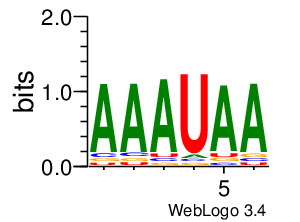

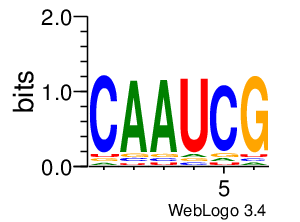

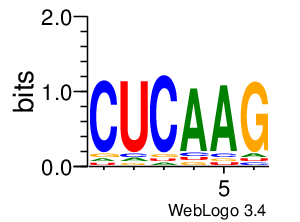

In [37]:
print 'Examples:'

max_chars=100
for id_clus in range(n_motives):
    print 
    print 'Cluster: %d' % id_clus
    for i,( h,s) in enumerate(pos_seqs[:16]):
        id = i % n_motives
        if id == id_clus:
            print s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2], s[:max_chars]

            
from collections import defaultdict

true_motives = defaultdict(list)
for i,( h,s) in enumerate(pos_seqs):
    id = i % n_motives
    true_motives[id].append((h,s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]))
from eden.sequence_motif_decomposer import Weblogo
wl= Weblogo(resolution=200,stacks_per_line=60, sequence_type='rna')

for id in true_motives:
    logo = wl.create_logo(true_motives[id])
    from IPython.display import Image, display
    display(Image(logo))

Cluster id: 3  (# seqs: 220) cons: AAAUAA  regex: AAAUAA
AAAUAA


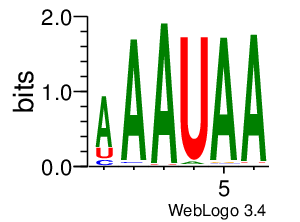

Cluster id: 3  (# seqs: 220) cons: AAAUAA  regex: AAAUAA
AAAUAA


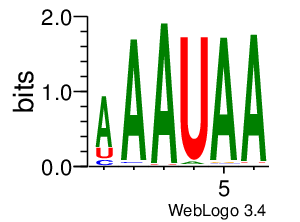

Cluster id: 6  (# seqs: 208) cons: CCUCAAGC  regex: ()CUCAAG()
CCUCAAGC


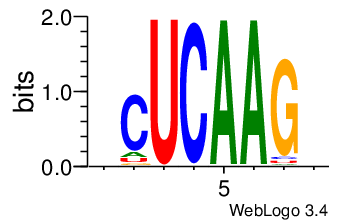

Average score: 0.72


In [38]:
pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
orig_clusters = smod.predict(test_pos_seqs)
clusters, motives = smod.merge(orig_clusters, 
                               similarity_threshold=0.5,
                               min_score=4,
                               min_freq=.5,
                               min_cluster_size=10)
clusters, motives = smod.frequency_filter(test_pos_seqs, motives, freq_threshold=.1)
selected = select_best_matching(motives, orig_motives)
selected = list(selected)
logos = smod.display_logos(selected)
avg_score = np.mean([s for s in best_matching_scores(motives, orig_motives)])
print 'Average score: %.2f' % avg_score

# Full analysis

Confusion matrix:
[[2778  222]
 [1000  500]]
Classification:
             precision    recall  f1-score   support

         -1       0.74      0.93      0.82      3000
          1       0.69      0.33      0.45      1500

avg / total       0.72      0.73      0.70      4500

ROC: 0.719
Cumulative score ROC: 1.00


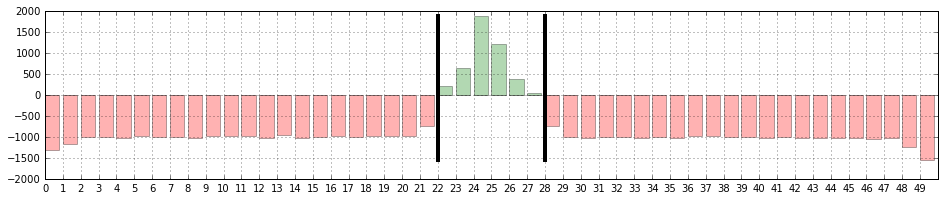

High quality motives
Cluster id: 0  (# seqs: 327) cons: GCUCAAG  regex: ()CUCAAG
GCUCAAG


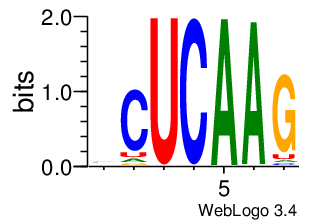

Cluster id: 1  (# seqs: 395) cons: CAAUCG  regex: CAAUCG
CAAUCG


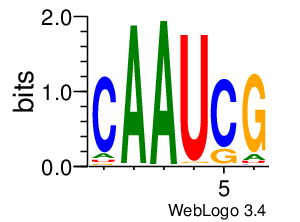

Cluster id: 2  (# seqs: 247) cons: AAAUAA  regex: AAAUAA
AAAUAA


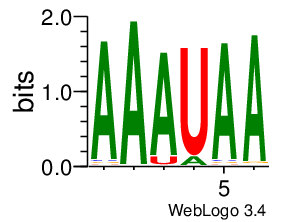

Cluster id: 6  (# seqs: 95) cons: GCAAU  regex: GCAAU
GCAAU


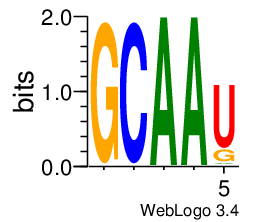

CPU times: user 3 s, sys: 860 ms, total: 3.86 s
Wall time: 36.4 s


In [39]:
%%time

pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
smod.performance(test_pos_seqs, test_neg_seqs)
plot_cumulative_score(smod, test_pos_seqs, sequence_length=sequence_length, motif_length=motif_length)
orig_clusters = smod.predict(test_pos_seqs)
clusters, motives = smod.merge(orig_clusters, 
                               similarity_threshold=0.5,
                               min_score=min_subarray_size+2,
                               min_freq=.6,
                               min_cluster_size=30)
clusters, motives = smod.frequency_filter(test_pos_seqs, motives, freq_threshold=.1)
print 'High quality motives'
logos = smod.display_logos(motives)

---